# Impact of heavy rain on US corn yields

Corey Lesk

* Much research has been published in the past decade on the effect of seasonal weather variability on global crop yields. Recently, there as been increasing attention to the influence of sub-seasonal extreme weather like extreme heat and drought on crops. But I haven't found any recorded attempt to asses the yield impact of heavy rain, which should damage crops directly and through soil waterlogging and nutrient leaching. 


* Fortunately, a colleague compiled a dataset of county-level crop yields and extreme rainfall events over the past ~40 years which we can analyze to fill this void. The dataset consists of an unwielded hierachy of nested dictionaries containing various data.

***

## Analysis

In [106]:
import pickle
import gzip
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
import pandas as pd



### 1. Load and make sense of the data. There is a groupedData file and then more detailed individual state files which are all pickled. 
   #### They contain at the county level:
     * hourly temperature and precipitation from nearest weather station 
     * annual corn yield
     * missing data fractions

In [107]:
# to get the list of counties...
#use gzip open read mode
mergedCropWx = {}
with gzip.open('merged-crop-wx-ca.pgz', 'r') as f:
    mergedCropWx = pickle.load(f)
mergedCropWx.keys()

dict_keys(['glenn', 'other (combined) counties', 'sacramento', 'solano', 'yolo', 'kern', 'merced', 'san joaquin', 'sutter', 'stanislaus', 'colusa', 'kings', 'tulare', 'butte', 'fresno', 'tehama', 'yuba', 'madera', 'san bernardino', 'contra costa', 'imperial', 'riverside', 'humboldt', 'placer', 'santa barbara', 'alameda', 'sonoma', 'siskiyou', 'san diego', 'san luis obispo', 'amador', 'shasta', 'san benito', 'monterey', 'santa clara', 'los angeles', 'ventura', 'san mateo', 'calaveras', 'lassen', 'modoc', 'lake', 'mendocino', 'el dorado', 'orange'])

Text(0,0.5,'Yield')

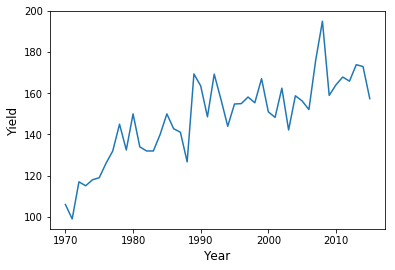

In [108]:
# yield dictionary keys are years and values are annual yields
years = list(mergedCropWx['sacramento']['yield'].keys())
yields = list(mergedCropWx['sacramento']['yield'].values())

plt.plot(years, yields)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Yield',fontsize=12)


### The corn yield data are of correct order of magnitude, increasing trend and variability are expected. Let's look at growing season mean temperatures and rainfall for a sample year of 2014:

Text(0.5,1,'Annual mean temperature in Sacramento county, CA')

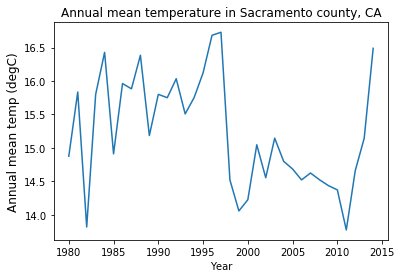

In [109]:
import numpy

# get all temps and associated year
years = numpy.array(mergedCropWx['sacramento']['year']).astype('float')
temps = numpy.array(mergedCropWx['sacramento']['temp']).astype('float')

annualMeanTemps = []

# loop over all years
uniqueYears = numpy.unique(years)
uniqueYears = uniqueYears[~numpy.isnan(uniqueYears)]

for y in uniqueYears:
    
    # find indices of this year
    ind = numpy.where(years == y)
    
    # take mean of all temps in that year
    annualMean = numpy.nanmean(temps[ind])
    annualMeanTemps.append(annualMean)


plt.plot(uniqueYears, annualMeanTemps)
plt.xlabel('Year')
plt.ylabel('Annual mean temp (degC)',fontsize=12)
plt.title('Annual mean temperature in Sacramento county, CA',fontsize=12)

Text(0.5,1,'Hourly precip in 2014')

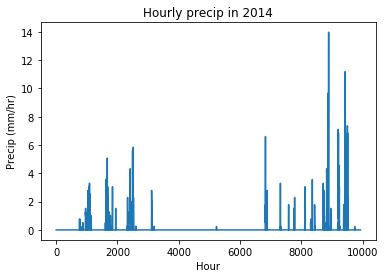

In [110]:
# get all hourly rainfall and associated year
years = numpy.array(mergedCropWx['sacramento']['year']).astype('float')
precip = numpy.array(mergedCropWx['sacramento']['precip']).astype('float')

ind = numpy.where(years == 2014)

plt.plot(precip[ind])
plt.xlabel('Hour')
plt.ylabel('Precip (mm/hr)')
plt.title('Hourly precip in 2014')

### These data are sensible. Now check data availability:

In [111]:
# How many nans are there in each county's temp and precip records...

for county in mergedCropWx.keys():
    # if this county has a matched station
    if len(mergedCropWx[county]) > 0:
        tempNans = numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['temp'])))
        precipNans = numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['precip'])))

        # convert to percent
        tempNans = tempNans / float(numpy.size(mergedCropWx[county]['temp'])) * 100
        precipNans = precipNans / float(numpy.size(mergedCropWx[county]['precip'])) * 100

        print(county + ":", str(round(tempNans)) + '% temp nan, ' + str(round(precipNans)) + '% precip nan')

sacramento: 2% temp nan, 87% precip nan
solano: 0% temp nan, 75% precip nan
yolo: 2% temp nan, 21% precip nan
kern: 2% temp nan, 38% precip nan
merced: 3% temp nan, 84% precip nan
san joaquin: 2% temp nan, 87% precip nan
sutter: 2% temp nan, 86% precip nan
stanislaus: 1% temp nan, 87% precip nan
kings: 3% temp nan, 90% precip nan
tulare: 1% temp nan, 83% precip nan
butte: 1% temp nan, 75% precip nan
fresno: 2% temp nan, 89% precip nan
tehama: 2% temp nan, 85% precip nan
yuba: 1% temp nan, 75% precip nan
contra costa: 37% temp nan, 86% precip nan
imperial: 1% temp nan, 90% precip nan
riverside: 1% temp nan, 90% precip nan
humboldt: 0% temp nan, 10% precip nan
placer: 0% temp nan, 9% precip nan
santa barbara: 1% temp nan, 45% precip nan
alameda: 4% temp nan, 76% precip nan
sonoma: 3% temp nan, 83% precip nan
siskiyou: 3% temp nan, 88% precip nan
san diego: 0% temp nan, 77% precip nan
san luis obispo: 2% temp nan, 86% precip nan
amador: 0% temp nan, 40% precip nan
shasta: 3% temp nan, 85%

### Examine missing data (count of nans) across all states in the underlying data files:

In [112]:
#now look at nan counts across all states:

import glob

# find all compressed merged crop/wx files
files = glob.glob('*.pgz')

# loop over all files (states)
for file in files:
    
    # get current state abrev
    parts = file.split('-')
    parts = parts[-1].split('.')
    state = parts[0]
    
    mergedCropWx = {}
    
    # load current file and de-pickle
    with gzip.open(file, 'rb') as f:
        mergedCropWx = pickle.load(f)
    
    totalTempLen = 0
    totalPrecipLen = 0
    tempNans = 0
    precipNans = 0
    
    # loop over all counties
    for county in mergedCropWx.keys():
        
        # if this county has a matched station
        if len(mergedCropWx[county]) > 0:
            # count up nans for each county
            tempNans += numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['temp'])))
            precipNans += numpy.size(numpy.where(numpy.isnan(mergedCropWx[county]['precip'])))

            # and count up all days
            totalTempLen += float(numpy.size(mergedCropWx[county]['temp']))
            totalPrecipLen += float(numpy.size(mergedCropWx[county]['precip']))
    
    tempPercent = tempNans / totalTempLen * 100
    precipPercent = precipNans / totalPrecipLen * 100
    
    print(state + ':', str(round(tempPercent)) + '% temp nan, ' + str(round(precipPercent)) + '% precip nan')
    
    

al: 1% temp nan, 67% precip nan
ar: 2% temp nan, 74% precip nan
az: 2% temp nan, 85% precip nan
ca: 3% temp nan, 79% precip nan
co: 2% temp nan, 77% precip nan
de: 4% temp nan, 83% precip nan
fl: 1% temp nan, 77% precip nan
ga: 2% temp nan, 59% precip nan
ia: 1% temp nan, 79% precip nan
id: 3% temp nan, 83% precip nan
il: 1% temp nan, 66% precip nan
in: 2% temp nan, 62% precip nan
ks: 1% temp nan, 78% precip nan
ky: 4% temp nan, 72% precip nan
la: 2% temp nan, 69% precip nan
md: 2% temp nan, 73% precip nan
mi: 1% temp nan, 79% precip nan
mn: 1% temp nan, 64% precip nan
mo: 1% temp nan, 63% precip nan
ms: 1% temp nan, 72% precip nan
mt: 3% temp nan, 87% precip nan
nc: 1% temp nan, 71% precip nan
nd: 1% temp nan, 53% precip nan
ne: 0% temp nan, 74% precip nan
nj: 3% temp nan, 77% precip nan
nm: 4% temp nan, 84% precip nan
ny: 1% temp nan, 78% precip nan
oh: 1% temp nan, 59% precip nan
ok: 1% temp nan, 71% precip nan
or: 3% temp nan, 79% precip nan
pa: 2% temp nan, 78% precip nan
sc: 1% t

### Clearly we need to be careful to exclude counties with excessive missing data.

### Data files named "grouped-data.dat" contain the full summarized crop-weather dataset with extreme rainfall years identified with boolean vectors. 

In [113]:
#load in grouped data file
groupedData = {}
with open('grouped-data-9995-34C-30mm.dat', 'rb') as f:
    groupedData = pickle.load(f)
groupedData['al']['jackson']

{'distance': 8.701202585672405,
 'isAbsPrecipGroup': [False, True, False, False, False],
 'isAbsTempGroup': [True, True, True, True, True],
 'isPrecipGroup': [False, True, False, True, False],
 'isTempGroup': [True, True, False, False, False],
 'meanTemp': [22.335852026761117,
  22.167688679245284,
  21.33844502376936,
  21.711225036345549,
  22.504575163398695],
 'precipMissingFraction': [0.9629338160069253,
  0.9672955974842767,
  0.9523846035884067,
  0.9609763562629122,
  0.9634015069967707],
 'precipThresh': 25.7009900000001,
 'tempMissingFraction': [0.00015739356260324744,
  0.0,
  0.0,
  0.0,
  7.688759034296666e-05],
 'tempThresh': 36.0,
 'totalPrecip': [1355.6300000000001,
  957.39999999999998,
  1063.02,
  855.47000000000003,
  280.25],
 'year': [2011, 2012, 2013, 2014, 2015],
 'yield': [117.3, 109.8, 131.9, 149.9, 147.7]}

### From this grouped weather/crop dataset, we can pull key years for various weather extreme categories, filtering events with poor data quality and continuity. We need to compute anomalies for each stretch of continuous yield data separately, so let's also parse out the sections of complete data prepare data for analysis:

In [114]:

# Derive sample key years from the full grouped dataset:
import itertools
absMode = 0
missing_data_threshold = 0.2

# Function to pull consecutive years, which we need to estimate yield anomaly
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

#Function to find consec year list (sub) starting index in full years (full)
def yearSubFind(sub, full):
    """Fill in doc string"""
    #loop to begin searching in full array, setting max index such that loop ends once too few indices remain to contain sub..
    for i in range(len(full)-len(sub)+1):
        #starting at index i, loop over indices in sub
        for j in range(len(sub)):
            #if this subset is not sub, move to next index in sub
            if full[i+j] != sub[j]:
                break
        #if match not found, move to next starting index in full
        else:
            return i
    #if no match found, return false. this should not occur in our cleaned data and serves as a test.
    return False

# declare result dict called samples
samples = {}

# over all states
for state in groupedData.keys():
    
    #declare empty sub-dict for this state
    samples[state] = {}
    
    # over all counties
    for county in groupedData[state].keys():
        
        # first check average annual data availability and exclude this county if below threshold
        if len(groupedData[state][county]['year']) > 0:   
            if numpy.nanmean(groupedData[state][county]['precipMissingFraction']) > missing_data_threshold:
                continue
        #also exlcude county if missing data altogether
        else:
            continue
        
        
        #if this county has data, create a new sub-dict for it, contains:
        #consec_years - consecutive years with complete data
        #tex_yrs - years with exclusive temp extremes within consec years
        #pex_yrs - years with exclusive rain extremes within consec years
        #joint_yrs - years with both rain and temp extremes within consec years
        #above three keys _abs_ - years with absolute rather than quantile extremes
        #fracs - fraction of total consecutive years
        samples[state][county] = {'consec_years':[], 
                                  'tex_yrs':[], 
                                  'pex_yrs':[], 
                                  'joint_yrs':[], 
                                  #'tex_abs_yrs':[], 
                                  'pex_abs_yrs':[],
                                  #'joint_abs_yrs':[],
                                  'fracs':[],
                                  #'fracs_abs':[],
                                  'yields':[]
                                 }
        
        #set minimum number of consecutive years of data to include in samples
        consec_year_limit = 5
        
        #extract sets of >5 consecutive years
        yrs = numpy.array(groupedData[state][county]['year'])
        grps = group_consecutives(yrs, step=1)
        for g in grps:
            if len(g)>=consec_year_limit:
                samples[state][county]['consec_years'].append(g)
        
        #if there are no sets of consecutive years, skip this county:
        if not (samples[state][county]['consec_years']):
            del samples[state][county]
            continue
        
        
        #merge consec yr lists:
        consec_yrs_merged = list(itertools.chain(*samples[state][county]['consec_years']))
            
        #boolean set logic: pull joint, exlusive precip, and exclusive temp extreme years and trim to consecutive range:
        samples[state][county]['joint_yrs']=list( (set(yrs[groupedData[state][county]['isTempGroup']]) & set(yrs[groupedData[state][county]['isPrecipGroup']])) & set(consec_yrs_merged) ) 
        samples[state][county]['pex_yrs']=list( (set(yrs[groupedData[state][county]['isPrecipGroup']]) - set(yrs[groupedData[state][county]['isTempGroup']])) & set(consec_yrs_merged) )
        samples[state][county]['tex_yrs']=list( (set(yrs[groupedData[state][county]['isTempGroup']]) - set(yrs[groupedData[state][county]['isPrecipGroup']])) & set(consec_yrs_merged) )
        samples[state][county]['pex_abs_yrs']=list( set(yrs[groupedData[state][county]['isAbsPrecipGroup']])  & set(consec_yrs_merged) )
            
        #compute fraction of consecutive years with quantile and absolute rain extremes
        samples[state][county]['fracs'] = [len(samples[state][county]['pex_yrs'])/len(consec_yrs_merged)]
        samples[state][county]['fracs_abs'] = [len(samples[state][county]['pex_abs_yrs'])/len(consec_yrs_merged)]

        #declare new list yield subsets corresponding to consecutive compelete data periods
        yieldSub=list()

        #loop over consec year sublists as there can be mulitple periods of consecutive complete data
        for consec_years_sub in samples[state][county]['consec_years']:
    
            consecYrStart = yearSubFind(consec_years_sub,groupedData[state][county]['year']) #find starting index of ith consec year list
            yieldSub.append(groupedData[state][county]['yield'][consecYrStart:consecYrStart+len(consec_years_sub)]) #grab corresponding yield

        samples[state][county]['yields']=yieldSub
        
        if absMode:
                 #same as above but for absolute extremes
            samples[state][county]['joint_abs_yrs']=list( (set(yrs[groupedData[state][county]['isAbsTempGroup']]) & set(yrs[groupedData[state][county]['isAbsPrecipGroup']])) & set(consec_yrs_merged) ) 
            samples[state][county]['pex_abs_yrs']=list( (set(yrs[groupedData[state][county]['isAbsPrecipGroup']]) - set(yrs[groupedData[state][county]['isAbsTempGroup']])) & set(consec_yrs_merged) )
            samples[state][county]['tex_abs_yrs']=list( (set(yrs[groupedData[state][county]['isAbsTempGroup']]) - set(yrs[groupedData[state][county]['isAbsPrecipGroup']])) & set(consec_yrs_merged) )
            samples[state][county]['fracs_abs'] = [len(samples[state][county]['pex_abs_yrs'])/len(consec_yrs_merged)]
            
        #optional printouts for checking
        teston=1;
        if teston:
            print (county,state)
            print(samples[state][county]['pex_yrs'])
            print(samples[state][county]['tex_yrs'])
            print(samples[state][county]['joint_yrs'])
            print(samples[state][county]['consec_years'])        
            print(samples[state][county]['fracs'])
            print(samples[state][county]['yields'])
                


arkansas ar
[1994, 1995]
[2009, 2010, 2011, 2012, 2013, 2015]
[1996]
[[1992, 1993, 1994, 1995, 1996, 1997], [2009, 2010, 2011, 2012, 2013, 2014, 2015]]
[0.15384615384615385]
[[135.4, 110.9, 144.8, 140.0, 140.3, 133.3], [160.0, 171.9, 160.9, 188.6, 199.0, 188.9, 189.1]]
crittenden ar
[2009]
[]
[2008, 2010, 2011, 2007]
[[2007, 2008, 2009, 2010, 2011]]
[0.2]
[[165.0, 132.0, 167.0, 169.0, 139.1]]
lonoke ar
[2007, 2008, 2009, 2013, 2014, 2015]
[1986]
[2010, 2011, 2012]
[[1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993], [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]]
[0.2608695652173913]
[[100.0, 130.0, 110.0, 127.0, 130.0, 130.0, 111.0, 117.6, 153.3, 114.3], [166.0, 153.0, 151.0, 164.0, 191.0, 168.0, 169.0, 175.0, 157.6, 189.1, 197.8, 198.9, 190.0]]
monroe ar
[]
[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2015]
[]
[[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]]
[0.0]
[[162.0, 145.0, 147.0, 143.0, 137.8, 177.4, 182.4, 184.2, 180.3]]
prairie

mercer il
[1985, 1986, 1992, 1993, 1994, 1996, 1997, 1998, 2000, 2001, 2002, 2003, 2004, 1982, 2009, 2010, 2014]
[2013, 2006]
[1984, 1987, 1988, 1989, 1990, 1991, 1995, 1999, 2005, 2011, 2012, 1983]
[[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]]
[0.4722222222222222]
[[115.0, 134.0, 124.0, 96.0, 118.0, 119.0, 135.0, 121.0, 65.0, 72.0, 135.0, 120.0, 142.0, 122.0, 166.0, 122.0, 137.0, 125.0, 142.0, 151.0, 148.0, 158.0, 174.0, 176.0, 183.0, 155.0, 170.0, 192.0, 192.0, 176.0, 142.4, 161.9, 180.1, 177.1, 193.5, 205.7]]
ogle il
[1984, 1985, 1986, 1990, 1992, 1993, 1996, 1998, 1999, 2004, 2006, 2007, 2013, 1982]
[2012, 1980]
[1987, 1988, 1989, 1991, 1994, 1995, 2000, 2002, 2005, 2011, 1983]
[[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 20

greene mo
[1985, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2002, 2003, 2004, 1981]
[1984, 1983]
[1986, 1987, 1999, 2000, 1980, 1982]
[[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]]
[0.64]
[[26.0, 84.7, 66.0, 44.2, 78.5, 75.0, 69.0, 81.5, 76.0, 76.8, 81.3, 68.3, 115.0, 82.8, 71.0, 62.8, 80.0, 83.1, 69.3, 56.2, 104.3, 105.6, 91.7, 75.6, 128.0]]
jasper mo
[1996, 1997]
[1984, 1986, 2012, 1998, 2000, 2003, 2006, 2007, 2010, 2011, 1980]
[1999, 1983]
[[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]]
[0.06060606060606061]
[[20.8, 97.6, 102.0, 69.4, 66.8, 90.0, 97.8, 129.0, 65.6, 114.5, 82.2, 102.9, 142.5, 110.6, 90.0, 76.2, 115.1, 138.4, 121.7, 90.9, 149.0, 139.6, 109.2, 109.8, 143.8, 90.8, 113.0, 123.0, 111.0, 136.0, 

okmulgee ok
[]
[2002, 2006]
[]
[[2001, 2002, 2003, 2004, 2005, 2006, 2007]]
[0.0]
[[79.2, 77.8, 81.0, 75.0, 75.0, 50.0, 121.1]]
ottawa ok
[2002, 2003, 2005, 2008, 2009, 2013, 2014]
[2001, 2006]
[2010, 2011, 2012]
[[2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]]
[0.5]
[[91.9, 89.2, 102.2, 98.0, 92.7, 95.0, 135.4, 101.0, 73.0, 115.2, 10.4, 31.8, 77.4, 155.2]]
texas ok
[2002, 2004, 2005, 2007]
[]
[1999, 2000, 2001, 2003, 2006, 2008]
[[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]]
[0.4]
[[186.3, 170.3, 163.2, 161.0, 149.1, 200.0, 165.0, 162.5, 190.0, 174.0]]
mccurtain ok
[2005]
[]
[]
[[2005, 2006, 2007, 2008, 2009]]
[0.2]
[[82.5, 81.0, 120.0, 86.0, 69.0]]
caddo ok
[2004, 2005, 2007]
[2006]
[2001]
[[2001, 2002, 2003, 2004, 2005, 2006, 2007]]
[0.42857142857142855]
[[88.3, 90.0, 128.9, 110.0, 98.1, 94.7, 116.7]]
wagoner ok
[2003, 2005]
[]
[2001, 2004, 2006]
[[2001, 2002, 2003, 2004, 2005, 2006, 2007]]
[0.2857142857142857]
[[91.7, 98.0, 95.7

### Now loop through the dataset, estimate yield anomalies, and populate a pandas dataframe for ease of analysis

In [115]:
window = 5

rdf = pd.DataFrame(columns = ['State',
                              'County',
                              'Year',
                              'Type',
                              'yieldAnom',
                              'precipThresh',
                              'tempThresh',
                              'totalPrecip',
                              'meanTemp'])

#loop over states
for state in samples.keys():
    
    #loop over counties
    for county in samples[state].keys():

        #loop over continuous complete data stretches
        for i,yield_sub in enumerate(samples[state][county]['yields']):
    
            #First, shunt yield data to dataframe, smooth the yield data, and compute anoms
            yield_sub = {'y': yield_sub,
                         'year': samples[state][county]['consec_years'][i]
                        }
            yield_sub = pd.DataFrame(yield_sub,index=yield_sub['year'])
            #center=True argument to rolling => averages over the middle data points. Should test sensitivity of results to this choice.
            yield_sub['ysmooth']=yield_sub['y'].rolling(window,center=True).mean()
            yield_sub['yanom']=yield_sub['y']/yield_sub['ysmooth']-1
    
            #Next, find anoms for years of extremes types
            extreme_types = ['pex_yrs','tex_yrs','joint_yrs']
    
            for extype in extreme_types:
        
                for yr in samples[state][county][extype]:
            
                    #if this year is not in this set of consecutive years, skip this yr. 
                    #also skip if yanom is a NaN (smoothed yield denominator = 0 or data outside initial window for smoothing)
                    if yr in samples[state][county]['consec_years'][i] and ~numpy.isnan(yield_sub.get_value(yr,'yanom')):
                        #pull data into results dataframe
                        rdf.loc[len(rdf)+1] = [state,
                                               county,
                                               yr,
                                               extype,
                                               yield_sub.get_value(yr,'yanom'),
                                               groupedData[state][county]['precipThresh'],
                                               groupedData[state][county]['tempThresh'],
                                               groupedData[state][county]['totalPrecip'][groupedData[state][county]['year'].index(yr)],
                                               groupedData[state][county]['meanTemp'][groupedData[state][county]['year'].index(yr)]
                                              ] 
                                             
rdf.head(1000)       

,State,County,Year,Type,yieldAnom,precipThresh,tempThresh,totalPrecip,meanTemp
1,ar,arkansas,1994,pex_yrs,0.078344,95.97,38.0,302481.90,22.785229
2,ar,arkansas,1995,pex_yrs,0.045869,95.97,38.0,287211.12,23.473442
3,ar,arkansas,2011,tex_yrs,-0.086211,95.97,38.0,803157.68,24.699759
4,ar,arkansas,2012,tex_yrs,0.037061,95.97,38.0,795592.43,24.704601
5,ar,arkansas,2013,tex_yrs,0.073934,95.97,38.0,715943.14,23.008316
6,ar,crittenden,2009,pex_yrs,0.081466,97.04,37.2,374108.93,22.532152
7,ar,lonoke,1986,tex_yrs,-0.078727,99.38,40.6,300501.83,23.783716
8,ar,lonoke,2007,pex_yrs,0.132859,99.38,40.6,420371.14,22.904169
9,ar,lonoke,2008,pex_yrs,-0.031142,99.38,40.6,530033.86,22.054398
10,ar,lonoke,2009,pex_yrs,-0.018127,99.38,40.6,601935.31,21.456885


### Here is an example of yield anomaly computations:

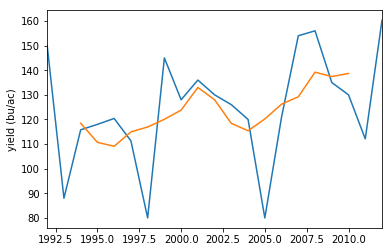

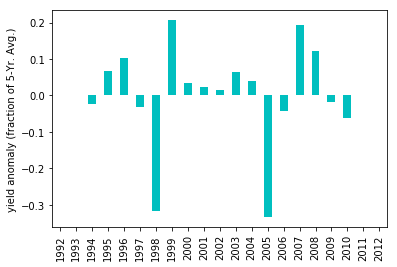

In [201]:
county = 'independence'
state = 'ar'

#declare new list yield subsets corresponding to consecutive compelete data periods
yieldSub=list()

#loop over consec year sublists as there can be mulitple periods of consecutive complete data
for consec_years_sub in samples[state][county]['consec_years']:
    
    consecYrStart = yearSubFind(consec_years_sub,groupedData[state][county]['year']) #find starting index of ith consec year list
    yieldSub.append(groupedData[state][county]['yield'][consecYrStart:consecYrStart+len(consec_years_sub)]) #grab corresponding yield

#####

yield_sub = {'y': yieldSub[0]}
yield_sub = pd.DataFrame(yield_sub,index=consec_years_sub)
yield_sub['ysmooth']=yield_sub['y'].rolling(5,center=True).mean()
yield_sub['yanom']=yield_sub['y']/yield_sub['ysmooth']-1

#yield_sub.plot()#loop over consec segments
fig,ax1 = plt.subplots()
yield_sub.y.plot()
yield_sub.ysmooth.plot()
plt.ylabel('yield (bu/ac)')
#plt.plot(samples[state][county]['consec_years'][0],numpy.array(yieldSub[0]))
#plt.plot(samples[state][county]['consec_years'][0][2:-2],smoothYield)

plt.savefig("yield_smoothing.pdf")

fig,ax2 = plt.subplots()
yield_sub.yanom.plot(kind='bar',color='c',sharex=ax1)
plt.ylabel('yield anomaly (fraction of 5-Yr. Avg.)')

plt.savefig("yanoms.pdf")

## 3. Analyze yield anomalies.

### First, let's see what level of hourly rain extreme corresponds to each group:

Fraction of pex years with precip thresh of 100


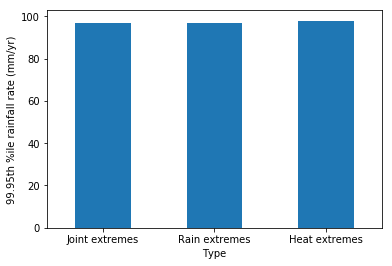

In [200]:
fig,ax2 = plt.subplots()
rdf.groupby('Type')['precipThresh'].mean().plot(kind='bar',ax=ax2)
plt.ylabel('99.95th %ile rainfall rate (mm/yr)')
print('Fraction of pex years with precip thresh of 100')
rdf[(rdf.Type == 'pex_yrs') & (rdf.precipThresh == 100)]['State'].count()/rdf[(rdf.Type == 'pex_yrs')]['State'].count()
plt.xticks((0,1,2),('Joint extremes','Rain extremes','Heat extremes'),rotation='horizontal')

plt.savefig("Pthresh.pdf")

### Clearly, there is a bug in the dataset for most of the the 99.95%ile hourly rainfall thresholds to exactly =100, so we have to take the extreme event groupings at face value. Let's compare the distribution of anomalies: 

C:\Users\clesk\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


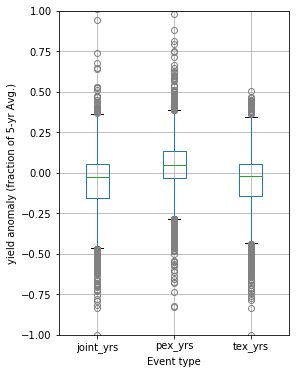

In [199]:
fig, ax = plt.subplots()
#set outlier style to reduce clutter
plt.rcParams['boxplot.flierprops.marker'] = 'o'
plt.rcParams['boxplot.flierprops.markeredgecolor'] = '0.5'
#make plot taller and narrower than default
fig.set_size_inches(4,6)
rdf.boxplot(column='yieldAnom', by='Type',ax=ax, labels=['a','b','c'])
plt.ylabel('yield anomaly (fraction of 5-yr Avg.)')
plt.xlabel('Event type')
plt.title('')
plt.ylim((-1,1))
plt.suptitle("")

plt.savefig("boxplot_yanom.pdf")

### Yields seem ~5% higher in years with rain extremes, but difference in medians seems much smaller than variance. Let's run an ANOVA with post-hoc Tukey HSD to check.

In [119]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#first parse out yield anoms for event types:
by_events_types = pd.unique(rdf.Type.values)
dat = {grp:rdf['yieldAnom'][rdf.Type == grp] for grp in by_events_types}
Fstat, pval = stats.f_oneway(dat['joint_yrs'], dat['tex_yrs'],dat['joint_yrs'])

print ('One-way ANOVA results:')

print ('F =', Fstat)
print ('P =', pval, '\n')

mc = MultiComparison(rdf.yieldAnom, rdf.Type)
result = mc.tukeyhsd()
print(result)


One-way ANOVA results:
F = 0.290972342305
P = 0.747543959528 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1   group2 meandiff  lower   upper  reject
-------------------------------------------------
joint_yrs pex_yrs  0.1066   0.096   0.1173  True 
joint_yrs tex_yrs  0.0035  -0.0081  0.015  False 
 pex_yrs  tex_yrs -0.1032  -0.1143 -0.0921  True 
-------------------------------------------------


### Looks like years with rainfall extremes have elevated yield compared joint or heat extremes. Let's regress the yield anomalies over total rainfall and see if this pattern holds even at the lower end of seasonal rainfall. Seaborn has some nice tools for visualizing trends in data so let's get that in here. We have a lot of points in this dataset so lets use hex to visualize relationship via density of points:

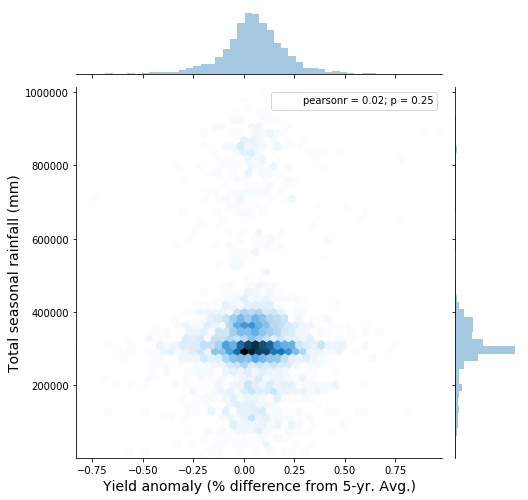

In [198]:
import seaborn
a=seaborn.jointplot('yieldAnom', 'totalPrecip', rdf[(rdf.Type == 'pex_yrs')], size=7, kind='hex') \
.set_axis_labels('Yield anomaly (% difference from 5-yr. Avg.)','Total seasonal rainfall (mm)',fontsize=14)
plt.savefig("totalP_vs_yanom.pdf")

### The slope coefficient of the linear regression is not significant, but the totals are in the km of rain/yr so clearly the bugs are hampering our understanding here. Let's look at trends versus mean seasonal temperature:

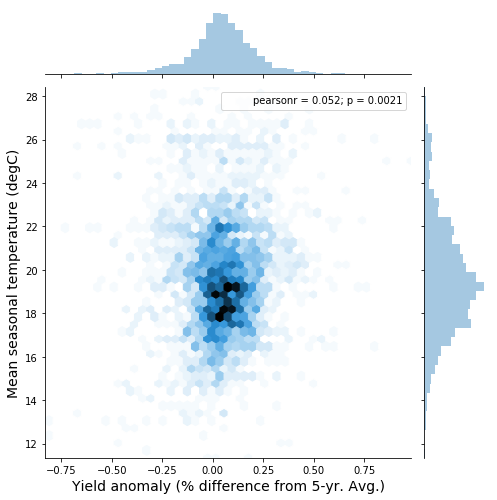

In [197]:
seaborn.jointplot('yieldAnom', 'meanTemp', rdf[(rdf.Type == 'pex_yrs')], size=7, kind='hex')\
.set_axis_labels('Yield anomaly (% difference from 5-yr. Avg.)','Mean seasonal temperature (degC)',fontsize=14)
plt.savefig("meanT_vs_yanom.pdf")

### Clearly the bug in the rainfall data is affecting seasonal totals too. This calls into question whether our rain extremes sample is legitimate. For now, let's map them. First we need to merge in county centroid lon/lat data to enable the mapping. 

In [196]:
#load county geographic data for mapping:
county_data = pd.read_csv('county_data.csv',encoding = "ISO-8859-1")
#our crop/weather data are all lowercase, so drop this geographic data down to lwrcase
county_data = county_data.apply(lambda x: x.astype(str).str.lower())
rdf = pd.merge(left=rdf,right=county_data, how='left', on=['State', 'County'])


In [95]:
from mpl_toolkits.basemap import Basemap

In [195]:
mapdat = rdf[(rdf.Type == 'tex_yrs')].groupby(['Latitude','Longitude']).mean()
lat=mapdat.index.get_level_values(0)
lon=mapdat.index.get_level_values(1)
lat=numpy.array(lat,dtype='double')
lon=numpy.array(lon,dtype='double')
lon=-1*lon
yanoms = numpy.array(mapdat.yieldAnom.values)

C:\Users\clesk\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\clesk\AppData\Local\conda\conda\envs\geo_scipy\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


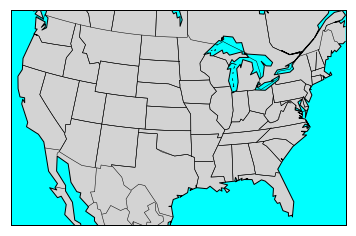

In [194]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawmapboundary(fill_color='aqua')
m.drawcountries()
m.fillcontinents(color='lightgray',lake_color='aqua')
m.drawcoastlines()
m.drawstates()
m.hexbin(lon, lat, C=yanoms, gridsize=20, mincnt=1, cmap='summer')

#couldn't get the hexbin to plot